In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import random
import cv2
from tqdm import tqdm
import dgl
import networkx as nx

Using backend: pytorch


In [2]:
from torchvision.datasets import STL10
from torchvision import transforms
 
STL10_train = STL10("STL10", split='train', download=True, transform=transforms.ToTensor())
 
STL10_test = STL10("STL10", split='test', download=True, transform=transforms.ToTensor())


2640397312it [02:33, 17191852.47it/s]                                


Extracting STL10/stl10_binary.tar.gz to STL10
Files already downloaded and verified


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
akaze=cv2.AKAZE_create()
graphs=[]
labels=[]
size=(512,512)
node_num=200
test_number=100444

for image,label in tqdm(STL10_train):
    #動作テスト
    #if test_number<0:
    #    break
    #else:
    #    test_number-=1

    #画像拡大　特徴抽出
    img=image.numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    kp,des=akaze.detectAndCompute(img,None)

    #上位抜出し
    dec=np.empty([len(kp)])
    for i in range(len(kp)):
        dec[i]=kp[i].response
    dec_sort_index=np.argsort(dec) #大きい順のインデックスを格納した配列


    if len(kp)<node_num: #もしkpの数がnode_num以下だった場合ノード数len(kp)個のグラフを作成
        top_des=torch.tensor(des,dtype=torch.float32)
        g=nx.complete_graph(len(des))
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des
    else:#kpの数がnode_num以上であればこちら
        #強度が大きい順にノード数分のdesを格納
        top_des=torch.empty(node_num,61,dtype=torch.float32)
        for i in range(1,node_num+1):
            top_des[i-1]=torch.from_numpy(des[dec_sort_index[-i]]).clone()

        #グラフ作成 networkx -- dgl経由
        g=nx.complete_graph(node_num)
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des

    #graphs代入　labels代入
    graphs.append(G)
    labels.append(label)

#グラフの保存
output_labels={'label':torch.tensor(labels)}
path=f'../data/STL10 Datasets/train/nnum{node_num}_ndatades_enone.dgl'
dgl.save_graphs(path,g_list=graphs,labels=output_labels)
    

100%|██████████| 5000/5000 [09:36<00:00,  8.68it/s]


In [5]:
akaze=cv2.AKAZE_create()
graphs=[]
labels=[]
size=(512,512)
node_num=200
test_number=10044444
none_num=0
for image,label in tqdm(STL10_test):
    #動作テスト
    #if test_number<0:
    #    break
    #else:
    #    test_number-=1

    #画像拡大　特徴抽出
    img=image.numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    kp,des=akaze.detectAndCompute(img,None)
    if len(kp) == 0:
        none_num+=1
        continue


    #上位抜出し
    dec=np.empty([len(kp)])
    for i in range(len(kp)):
        dec[i]=kp[i].response
    dec_sort_index=np.argsort(dec) #大きい順のインデックスを格納した配列


    if len(kp)<node_num: #もしkpの数がnode_num以下だった場合ノード数len(kp)個のグラフを作成
        top_des=torch.tensor(des,dtype=torch.float32)
        g=nx.complete_graph(len(des))
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des
    else:#kpの数がnode_num以上であればこちら
        #強度が大きい順にノード数分のdesを格納
        top_des=torch.empty(node_num,61,dtype=torch.float32)
        for i in range(1,node_num+1):
            top_des[i-1]=torch.from_numpy(des[dec_sort_index[-i]]).clone()

        #グラフ作成 networkx -- dgl経由
        g=nx.complete_graph(node_num)
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des

    #graphs代入　labels代入
    graphs.append(G)
    labels.append(label)

#グラフの保存
output_labels={'label':torch.tensor(labels)}
path=f'../data/STL10 Datasets/test/nnum{node_num}_ndatades_enone.dgl'
dgl.save_graphs(path,g_list=graphs,labels=output_labels)
    

100%|██████████| 8000/8000 [15:11<00:00,  8.78it/s]


In [7]:
print(none_num)

2


# 以下雑多

In [8]:
akaze=cv2.AKAZE_create()
c=0
for i,j in tqdm(STL10_train):
    img=i.numpy().transpose(1,2,0)
    img=cv2.resize(img,(512,512),interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    kp,des=akaze.detectAndCompute(img,None)
    if len(kp)<100:
        c+=1
print(c)

100%|██████████| 5000/5000 [01:22<00:00, 60.81it/s]

132


In [16]:
print(len(STL10_test))


8000


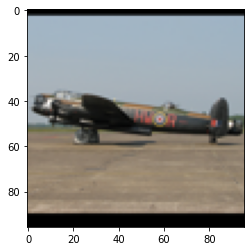

In [3]:
img=STL10_train[10][0]
img = img.permute(1,2,0)
plt.imshow(img)
plt.show()

In [25]:
for i in STL10_train:
    if i[1]==2:
        img=i[0].numpy().transpose(1,2,0)
    else:
        continue

<class 'numpy.ndarray'>
21 639


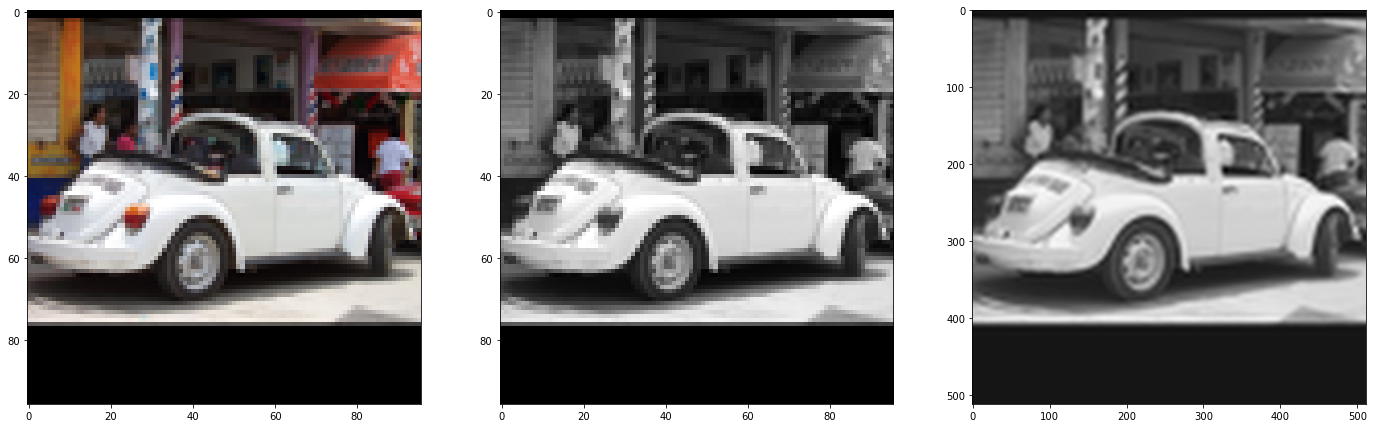

In [29]:
print(type(img))
plt.figure(figsize=(12*2,8*2))
akaze=cv2.AKAZE_create()
size=(512,512)

grayimg=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
upimg=cv2.resize(grayimg,size,interpolation=cv2.INTER_LANCZOS4)
kp,des=akaze.detectAndCompute(img,None)
upkp,updes=akaze.detectAndCompute(upimg,None)
print(len(kp),len(upkp))

plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(grayimg,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(upimg,cmap='gray')

plt.show()

In [38]:
akaze=cv2.AKAZE_create()
kps=[]
start=time.time()
for i in range(3):
    kp=akaze.detect(STL10_train[i][0].numpy().transpose(1,2,0))
print(time.time()-start)

0.003793478012084961


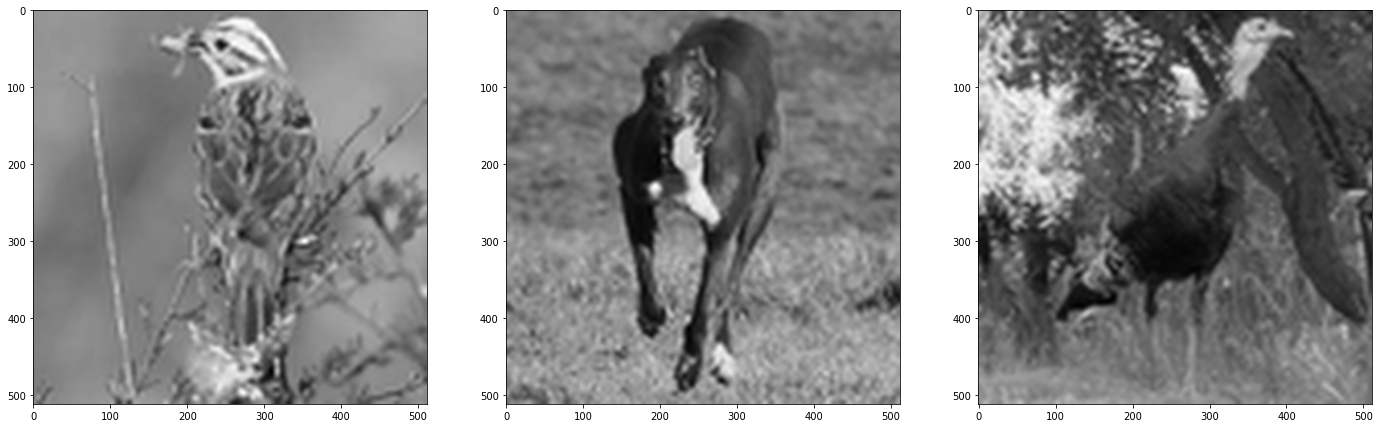

In [57]:
kps=[]
size=(512,512)
plt.figure(figsize=(12*2,8*2))
for i in range(3):
    img=STL10_train[i][0].numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    plt.subplot(1,3,i+1)
    plt.imshow(img,cmap='gray')
    kps.append(akaze.detectAndCompute(img,None)[0])
plt.show()

In [52]:
print(len(kps[2]))

337


In [38]:
g5=nx.complete_graph(5)
print(g5)
g5.add_nodes_from([(1,{'feat':[1,2,32,3,4,5,3452345,43,5,45,23]})])
g5.add_nodes_from([(2,{'feat':200})])
print(nx.get_node_attributes(g5,'feat'))

Graph with 5 nodes and 10 edges
{1: [1, 2, 32, 3, 4, 5, 3452345, 43, 5, 45, 23], 2: 200}


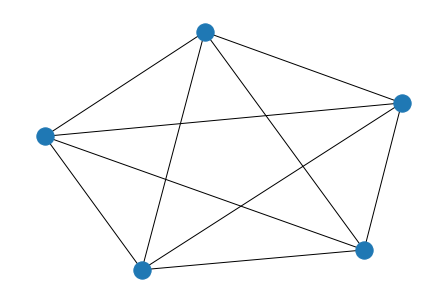

In [25]:
nx.draw(g5)
plt.show()

In [26]:
dglg5=dgl.from_networkx(g5)

In [27]:
print(dglg5)

Graph(num_nodes=5, num_edges=20,
      ndata_schemes={}
      edata_schemes={})
